In [1]:
import json
import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [3]:
BSM_SIZE = 18372145
N_FEATURES = 23

In [4]:
root_dir = 'MixAll_0024/'


# /VeReMi_82800_86400_2022-9-11_12:51:1
filenames = glob.glob(root_dir + '**/traceJSON*.json', recursive=True)

# filenames = filenames[:10000]

attacker_sender_map = {}


for filepath in filenames:
    filename = filepath.split('/')[-1]
    _, vehicle, _, attacker = filename.split('-')[:4] # Rever definições da nomenclatura
    attacker_type = int(attacker[1:])
    vehicle_id = int(vehicle)
    attacker_sender_map[vehicle_id] = attacker_type
             
bsm = np.memmap('bsm.memmap', dtype='float32', mode='w+', shape=(BSM_SIZE, N_FEATURES))
bsm_pos = 0
for filepath in (pbar := tqdm(filenames)):
    f = open(filepath)
    receiver = int(filepath.split('/')[-1].split('-')[1])
    pbar.set_description("Vehicle ID {}".format(receiver))
    gps = None
    for line in f:
        data = json.loads(line)
        if data['type'] == 2:
            gps = data
        elif data['type'] == 3:
            attack_type = attacker_sender_map.get(data['sender'], None)
            if attack_type is not None:
                out = (
                    data['messageID'],
                    data['rcvTime'],
                    data['sendTime'],
                    receiver,
                    data['sender'],
                    attack_type,
                    data['pos'][0],
                    data['pos'][1],
                    data['spd'][0],
                    data['spd'][1],
                    data['acl'][0],
                    data['acl'][1],
                    data['hed'][0],
                    data['hed'][1],
                    gps['rcvTime'],
                    gps['pos'][0],
                    gps['pos'][1],
                    gps['spd'][0],
                    gps['spd'][1],
                    gps['acl'][0],
                    gps['acl'][1],
                    gps['hed'][0],
                    gps['hed'][1],
                )
                bsm[bsm_pos] = out
                bsm_pos += 1

  0%|          | 0/24677 [00:00<?, ?it/s]

In [5]:
bsm = np.memmap('bsm.memmap', dtype='float32', mode='r', shape=(BSM_SIZE, N_FEATURES))

In [9]:
df = pd.DataFrame(bsm, columns=[
    'message_id',
    'bsm_rcv_time',
    'bsm_snd_time',
    'receiver',
    'sender',
    'attack_type',
    'snd_pos_x',
    'snd_pos_y',
    'snd_spd_x',
    'snd_spd_y',
    'snd_acl_x',
    'snd_acl_y',
    'snd_hed_x',
    'snd_hed_y',
    'gps_rcv_time',
    'rcv_pos_x',
    'rcv_pos_y',
    'rcv_spd_x',
    'rcv_spd_y',
    'rcv_acl_x',
    'rcv_acl_y',
    'rcv_hed_x',
    'rcv_hed_y',
]).drop_duplicates(subset='message_id')#.set_index('message_id')
df = df[df.message_id != 0]
df.drop(columns=['gps_rcv_time'], inplace=True)
df = df.sort_values(['sender', 'bsm_snd_time']).reset_index(drop=True)

df

,message_id,bsm_rcv_time,bsm_snd_time,receiver,sender,attack_type,snd_pos_x,snd_pos_y,snd_spd_x,snd_spd_y,...,snd_hed_x,snd_hed_y,rcv_pos_x,rcv_pos_y,rcv_spd_x,rcv_spd_y,rcv_acl_x,rcv_acl_y,rcv_hed_x,rcv_hed_y
0,20224.0,539.952881,539.952881,27.0,21.0,0.0,512.986877,305.169678,-15.149040,-5.259165,...,-0.945767,0.324845,353.846802,487.703766,-10.354825,-8.017405,0.142088,0.110049,-0.865982,-0.500076
1,20612.0,556.952881,556.952881,27.0,21.0,0.0,265.189453,220.888367,-6.655805,-1.069099,...,-0.893505,0.449054,232.997559,326.611816,1.945997,-12.940573,0.004992,-0.032269,-0.002337,-0.999997
2,20640.0,557.952881,557.952881,27.0,21.0,0.0,257.854950,219.774048,-8.339111,-1.232982,...,-0.909672,0.415328,234.831100,313.702209,1.936036,-12.874235,-0.135757,0.903735,0.005343,-0.999986
3,20668.0,558.952881,558.952881,27.0,21.0,0.0,248.314041,218.496826,-10.285843,-1.400385,...,-0.904841,0.425750,236.692490,300.783203,1.950060,-12.966295,0.028774,-0.190432,0.017375,-0.999849
4,20776.0,563.952881,563.952881,27.0,21.0,0.0,176.377747,210.376114,-15.914332,-1.640642,...,-0.880145,0.474706,246.170197,236.751953,1.626769,-10.816935,-0.669026,4.450094,0.031589,-0.999501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800868,437570880.0,86391.828125,86391.828125,147957.0,148065.0,0.0,865.453369,520.160583,-3.286072,2.044143,...,-0.847506,0.530785,869.593689,522.211304,9.687077,-6.865006,-0.785805,0.559469,0.811537,-0.584301
2800869,437571808.0,86392.828125,86392.828125,147957.0,148065.0,0.0,864.171692,521.022522,-0.703312,0.438220,...,-0.847137,0.531375,879.278320,515.901245,10.093508,-6.282318,-0.716920,0.448542,0.845081,-0.534639
2800870,437572576.0,86393.828125,86393.828125,147957.0,148065.0,0.0,862.619934,522.289856,-2.335815,1.611587,...,-0.820392,0.571801,889.516724,509.560577,10.072103,-6.447652,0.781166,-0.497921,0.838350,-0.545132
2800871,437573312.0,86394.828125,86394.828125,147957.0,148065.0,0.0,860.316650,525.306396,-3.295891,3.603786,...,-0.671363,0.741129,898.660095,502.365448,8.545646,-6.652068,-3.221239,2.510054,0.784707,-0.619867


In [10]:
# filter for prototyping
# df = df[:round(df.shape[0] * 0.1)]

split = round(df.shape[0] * 0.5)

train = df[:split]

filtered_train = train[train.attack_type < 10].drop(columns=['attack_type'])
filtered_train.to_csv('out_veremi/train.csv')

train = train.drop(columns=['attack_type'])
train.to_csv('out_veremi/train_no_filter.csv')

test = df[split:].drop(columns=['attack_type'])
test.to_csv('out_veremi/test.csv')

y = (df['attack_type'] >= 10)[split:].astype(int)

labels = pd.concat([y] * len(test.columns), ignore_index=True, axis=1)
labels.to_csv('out_veremi/labels.csv')

df_test_split = df[split:]

for i in range(10, 20):
    test_i = df_test_split[df_test_split.attack_type.isin((i, 0))].copy()
    
    y = (test_i.attack_type == i).astype(int)
    test_i.drop(columns=['attack_type'], inplace=True)
    
    labels_i = pd.concat([y] * len(test_i.columns), ignore_index=True, axis=1)

    test_i.to_csv(f'out_veremi/test_{i}.csv')
    labels_i.to_csv(f'out_veremi/labels_{i}.csv')

<Axes: >

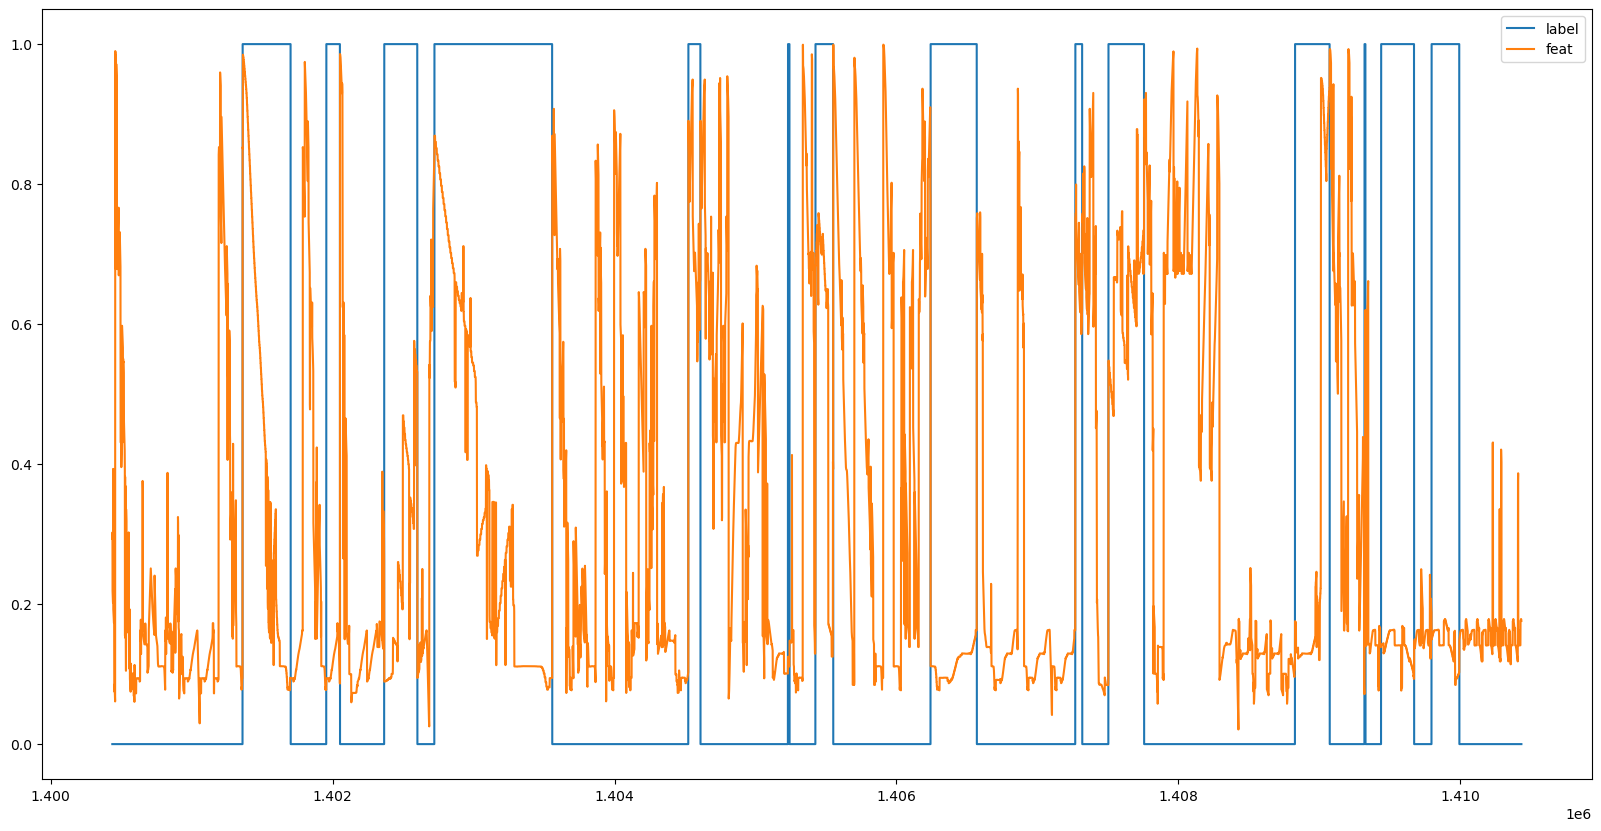

In [13]:
feat = test.rcv_pos_x

feat_norm = (feat - feat.min()) / (feat.max() - feat.min())

pd.DataFrame({ 'label': labels[0].head(10000), 'feat': feat_norm.head(10000) }).plot(figsize=(20,10))

In [ ]:
feat[feat.index ]